# Seq2Seq Model

Importing necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import time
import string
import re
import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import os

Now we load the data from json file and create a pandas data frame.
<br> 
After deleting duplicates the size of dataset was reduced from 7000-6971.
<br> 
I have also changed both the questions and answers to Upper Case.

In [2]:
df = pd.read_json('train_spider.json')
cols = ['question','query']
data=df[cols]
data=data.drop_duplicates()

#Changing Everything to Uppercase
data['query']=data['query'].str.upper()
data['question']=data['question'].str.upper()
data=data.drop_duplicates()
data.head()

,question,query
0,HOW MANY HEADS OF THE DEPARTMENTS ARE OLDER TH...,SELECT COUNT(*) FROM HEAD WHERE AGE > 56
1,"LIST THE NAME, BORN STATE AND AGE OF THE HEADS...","SELECT NAME , BORN_STATE , AGE FROM HEAD ORD..."
2,"LIST THE CREATION YEAR, NAME AND BUDGET OF EAC...","SELECT CREATION , NAME , BUDGET_IN_BILLIONS ..."
3,WHAT ARE THE MAXIMUM AND MINIMUM BUDGET OF THE...,"SELECT MAX(BUDGET_IN_BILLIONS) , MIN(BUDGET_I..."
4,WHAT IS THE AVERAGE NUMBER OF EMPLOYEES OF THE...,SELECT AVG(NUM_EMPLOYEES) FROM DEPARTMENT WHER...


 Here we only choose instances where the query has a where condition and a Join cloause. This kind of narrows down the problem and we only focus on 1 type oof question.

In [3]:
def DataSetWith1JoinAndWhere():
    df1= pd.DataFrame(columns=['query', 'question'])
    df1=pd.concat([df1,data.loc[data['query'].str.contains('WHERE', case=False)]],ignore_index=True, sort=False)
    df2= pd.DataFrame(columns=['query', 'question'])
    for x in range(len(df1)):
        if(df1.loc[x]['query'].count('JOIN')==1):
            df2=df2.append(df1.loc[x])
    return df2.drop_duplicates().reset_index()
df_final=DataSetWith1JoinAndWhere()[cols].sample(n=1000,random_state=1).reset_index()
del df_final['index']

# Train Validation Test Split
Train 75%, Validation 15%, Test 15%

In [4]:
# Creating Train Validation Test Split
# Creating Train Validation Test Split
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_final, target = 'query', random_state=1,
                                                                            train_size=0.7, valid_size=0.15, test_size=0.15)

# Cleaning The Train Data
<br> I have removed punctuation from Questions and changed short forms like What's to What is, So it is easier for the model to predict

In [5]:
#Cleaning Questions

def clean_text(text):
    text = text.upper()
    text = re.sub(r"WHATS'S", "WHAT IS", text)
    text = re.sub(r"WHERE'S", "WHERE IS", text)
    text = re.sub(r"\'LL", " WILL", text)
    text = re.sub(r"\'VE", " HAVE", text)
    text = re.sub(r"\'RE", " ARE", text)
    text = re.sub(r"\'D", " WOULD", text)
    text = re.sub(r"WON'T", "WILL NOT", text)
    text = re.sub(r"CAN'T", "CANNOT", text)
    text = re.sub(r"[\"#/@;:{}~|.?,]", "", text)
    for i in range(1,10):   
        text = re.sub(r"\ T"+str(i), " ", text)
    return text

clean_questions=[]
for question in X_train['question']:
    clean_questions.append(clean_text(question))

clean_queries=[]
for query in y_train:
    clean_queries.append(query)

# Tokenizing
Tokenizing is used to change the questions and queries to vector format. I have added 2 to Vocabulary size of both Questions and Queries to represent start of sentence and end of sentence added in subsequent step.
These vectors are saved in inputs and outputs respectively.
I have set the Max_length to 40 and removed all the instances where the queries or questions exceed this limit.

In [6]:
#Tokenizing
tokenizer_questions = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(clean_questions,
                                                                                target_vocab_size=2**13)
tokenizer_queries = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(clean_queries,
                                                                                target_vocab_size=2**13)
        
VOCAB_SIZE_QUESTIONS = tokenizer_questions.vocab_size+2
VOCAB_SIZE_QUERIES = tokenizer_queries.vocab_size+2

inputs =[[VOCAB_SIZE_QUESTIONS-2]+tokenizer_questions.encode(sentence)+[VOCAB_SIZE_QUESTIONS-1]
         for sentence in clean_questions]

outputs =[[VOCAB_SIZE_QUERIES-2]+tokenizer_queries.encode(sentence)+[VOCAB_SIZE_QUERIES-1]
         for sentence in clean_queries]

MAX_LENGTH=40
idx_to_remove =[count for count, sent in enumerate(inputs) if len(sent)>MAX_LENGTH]
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]
    
idx_to_remove =[count for count, sent in enumerate(outputs) if len(sent)>MAX_LENGTH]
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]
    
print(len(inputs))

601


# Padding
We use keras pad sequence to pad all the questions or queries which had length shorter than 40 to set all the inputs and outputs to have the same length.

In [7]:
#Padding Inputs and Outputs
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                                  value=0,padding='post',
                                                                  maxlen=MAX_LENGTH)
outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs,
                                                                  value=0,padding='post',
                                                                  maxlen=MAX_LENGTH)


In [8]:
#Printing Vocab size 
print('Vocab size of Questions: ',VOCAB_SIZE_QUESTIONS)
print('\nVocab size of Queries: ',VOCAB_SIZE_QUERIES)

Vocab size of Questions:  1796

Vocab size of Queries:  2019


In [9]:
#Getting vector dataset for training
dataset=tf.data.Dataset.from_tensor_slices((inputs,outputs))

Batch Size and Buffer size is used to shuffle the dataset.
<br>Cache is used to improve speed of training
<br>prefetch  with experimental.AUTOTUNE also speeds up training.

In [10]:
BATCH_SIZE=64
BUFFER_SIZE=20000

dataset=dataset.cache()
dataset=dataset.shuffle(BUFFER_SIZE).batch(BUFFER_SIZE)
dataset=dataset.prefetch(tf.data.experimental.AUTOTUNE)


Positional encoding formulae:

$PE_{(pos, 2i)} = \sin(pos/10000^{2i/dmodel})$  - Even positions

$PE_{(pos, 2i+1)} = \cos(pos/10000^{2i/dmodel})$ - Odd Positions

In [11]:
# Positional Encoding
class PositionalEncoding(layers.Layer):
    def __init__(self):
        super(PositionalEncoding,self).__init__()
    def get_angles(self,pos,i, d_model): #pos:(seq_length,1) i: (1,d_model)
        angles = i/np.power(10000.,(2*(i//2))/np.float32(d_model))
        return pos * angles #(seq_length,d_model)
    def call(self,inputs):
        seq_length = inputs.shape.as_list()[-2] # length of sequences
        d_model = inputs.shape.as_list()[-1] # last dimension
        angles=self.get_angles(np.arange(seq_length)[:,np.newaxis],
                               np.arange(d_model)[np.newaxis,:],
                               d_model)
        angles[:,0::2]=np.sin(angles[:,0::2]) # Applied to Even positions
        angles[:,1::2]=np.cos(angles[:,1::2]) # Applied to Odd positions
        pos_encoding=angles[np.newaxis,...] # We have one more dimension (...) means it takes everything
        return inputs+tf.cast(pos_encoding,tf.float32) # Making them tensors and adding to inputs

$Attention(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$

In [25]:
# Scaled Dot Product Attention
# Here the mask is look ahead mash which doesn't allow the decoder to see next words or 
# padding mask that masks zeros at end of each sentence
def scaled_dotproduct_attention(quries,keys,values,mask): 
    product=tf.matmul(quries,keys,transpose_b=True) # matrix multiplication of Q ad K 
    keys_dim=tf.cast(tf.shape(keys)[-1],tf.float32) # old dimension of keys
    scaled_product=product/tf.math.sqrt(keys_dim) # scaling by dividing by root of dimension of K
     # Appling mask and multiplying by very low -ve number so after softmask it will be 0 and won;t have any impact
    if mask is not None:
        scaled_product +=(mask*-1e9)
    attention=tf.matmul(tf.nn.softmax(scaled_product,axis=-1), values) # Applying Softmax and matrix multiplication with V
    return attention

### Multi-head attention sublayer

In [13]:
# Multihead Attention
class MultiHeadAttention(layers.Layer):
    def __init__(self,nb_proj): # nb_proj is number of projections wwe want to perform
        super(MultiHeadAttention,self).__init__()
        self.nb_proj=nb_proj
    def build(self,input_shape):
        self.d_model=input_shape[-1]
        # making sure d_model / nb_proj gives integers
        assert self.d_model % self.nb_proj == 0 
        
        self.d_proj=self.d_model//self.nb_proj # Dimension of each projection
        
        # Dense Layers
        self.query_lin = layers.Dense(units=self.d_model) 
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self,inputs,batch_size): # inputs: (batch_size, seq_length,d_model)
        shape = (batch_size,
                 -1, 
                 self.nb_proj, 
                 self.d_proj)
        splitted_inputs = tf.reshape(inputs,shape=shape) # We have this shape (batch_size,seq_length,np_proj, d_proj)
        # We use transpose to convert to this (batch_size, np_proj,seq_length,d_proj)
        return tf.transpose(splitted_inputs, perm =[0,2,1,3]) 
        
    def call(self, queries,keys,values,mask):
        batch_size=tf.shape(queries)[0]
        
        queries=self.query_lin(queries)
        keys=self.key_lin(keys)
        values=self.value_lin(values)
        
        queries = self.split_proj(queries,batch_size)
        keys = self.split_proj(keys,batch_size)
        values = self.split_proj(values,batch_size)

        attention = scaled_dotproduct_attention(queries,keys,values,mask) # Calling sclaed dot product for attention
        attention = tf.transpose(attention, perm = [0,2,1,3])
        
        concat_attention= tf.reshape(attention,
                                     shape=(batch_size,-1,self.d_model)) 
        
        outputs = self.final_lin(concat_attention)
        return outputs

# Encoder

In [14]:
class EncoderLayer(layers.Layer):
    
    def __init__(self,FFN_units, nb_proj, dropout):
        super(EncoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout = dropout
        
    def build(self, input_shape):
        self.d_model=input_shape[-1]
        self.multi_head_attention = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.dense_1 = layers.Dense(units=self.FFN_units,activation='relu')
        self.dense_2 = layers.Dense(units=self.d_model,activation='relu')
        self.dropout_2 = layers.Dropout(rate=self.dropout)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask, training):
        attention = self.multi_head_attention(inputs,inputs,inputs,mask)
        attention =self.dropout_1(attention, training=training)
        attention = self.norm_1(attention+inputs)
        outputs=self.dense_1(attention)
        outputs=self.dense_2(outputs)
        outputs =self.dropout_2(outputs)
        outputs = self.norm_2(outputs+attention)
        
        return outputs

In [15]:
class Encoder(layers.Layer):
    def __init__(self,
               nb_layers,
               FFN_units,
              nb_proj,
              dropout,
              vocab_size,
              d_model,
              name="encoder"):
        super(Encoder,self).__init__(name=name)
        self.nb_layers=nb_layers
        self.d_model=d_model
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout)
        self.enc_layers = [EncoderLayer(FFN_units,
                                        nb_proj,
                                        dropout)
                           for _ in range(nb_layers)]
        
    def call(self,inputs,mask,training):
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model,tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs,training)
        
        for i in range(self.nb_layers):
            outputs = self.enc_layers[i](outputs, mask, training)
            
        return outputs

# Decoder

In [16]:
class DecoderLayer(layers.Layer):
    def __init__(self,FFN_units, nb_proj, dropout):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout = dropout
        
    def build(self, input_shape):
        self.d_model=input_shape[-1]
        self.multi_head_attention_1 = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        self.multi_head_attention_2 = MultiHeadAttention(self.nb_proj)
        self.dropout_2 = layers.Dropout(rate=self.dropout)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dense_1 = layers.Dense(units=self.FFN_units,activation='relu')
        self.dense_2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        attention = self.multi_head_attention_1(inputs,
                                              inputs,
                                              inputs,
                                              mask_1)
        attention = self.dropout_1(attention, training)
        attention = self.norm_1(attention +  inputs)
        
        attention_2 = self.multi_head_attention_2(attention,
                                              enc_outputs,
                                              enc_outputs,
                                              mask_2)
        attention_2 = self.dropout_2(attention_2,training)
        attention_2 = self.norm_2(attention_2 +  attention)
        
        outputs = self.dense_1(attention_2)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_3(outputs, training)
        outputs = self.norm_3(outputs +  attention_2)
        
        return outputs

In [17]:
class Decoder(layers.Layer):
    def __init__(self,
               nb_layers,
               FFN_units,
              nb_proj,
              dropout,
              vocab_size,
              d_model,
              name='decoder'):
        super(Decoder, self).__init__(name=name)
        self.d_model=d_model
        self.nb_layers = nb_layers
        
        self.embedding =  layers.Embedding(vocab_size,d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout)
        
        self.dec_layers = [DecoderLayer(FFN_units, nb_proj,dropout)
                           for _ in range(nb_layers)]
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        outputs=self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model,tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs,training)
        
        for i in range(self.nb_layers):
            outputs = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         mask_1,
                                         mask_2,
                                         training)
        return outputs

# Transformer

In [18]:
# Transformer
class Transformer(tf.keras.Model):
    def __init__(self,vocab_size_enc,
              vocab_size_dec,
              d_model,
              nb_layers,
              FFN_units,
              nb_proj,
              dropout,
              name="transformer"):
        super(Transformer, self).__init__(name=name)
        
        self.encoder = Encoder(nb_layers,
                              FFN_units,
                              nb_proj,
                              dropout,
                              vocab_size_enc,
                              d_model)
        self.decoder = Decoder(nb_layers,
                              FFN_units,
                              nb_proj,
                              dropout,
                              vocab_size_dec,
                              d_model)
        
        self.last_linear = layers.Dense(units=vocab_size_dec)
        
    def create_padding_mask(self, seq): # seq: (batch_size,seq_length)
        mask = tf.cast(tf.math.equal(seq,0),tf.float32)
        return mask[:,tf.newaxis,tf.newaxis,:]
    
    # While translating we do not need to know future words.
    '''Creates a  square matrix of seq_len. if i>j matrix element is 1 else
    matrix element is 0'''
    def create_look_ahead_mask(self, seq):
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0)
        return look_ahead_mask
    
    def call(self, enc_inputs,dec_inputs, training):
        enc_mask=self.create_padding_mask(enc_inputs)
        dec_mask_1= tf.maximum(self.create_padding_mask(dec_inputs), 
                               self.create_look_ahead_mask(dec_inputs))
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        
        enc_outputs = self.encoder(enc_inputs,enc_mask, training)
        dec_outputs = self.decoder(dec_inputs,
                                   enc_outputs,
                                   dec_mask_1,
                                   dec_mask_2,
                                   training)
        
        outputs = self.last_linear(dec_outputs)
        return outputs
    

In [19]:
# Formula used for Look Ahead Mask
print(1 - tf.linalg.band_part(tf.ones((5,5)),-1,0))

tf.Tensor(
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)


# Application

## Training

In [20]:
# Training
tf.keras.backend.clear_session()

#Hyper parameters
D_MODEL=128 # 512 in All you need is Attention
NB_LAYERS=6 # 6
FFN_UNITS = 512 # 2048 in All you need is Attention
NB_PROJ = 8 # 8
DROUPOUT = 0.01 # 0.1 in All you need is Attention

transformer = Transformer(vocab_size_enc = VOCAB_SIZE_QUESTIONS, # 1796
                          vocab_size_dec = VOCAB_SIZE_QUERIES, # 2019
                          d_model= D_MODEL,
                          nb_layers=NB_LAYERS,
                          FFN_units=FFN_UNITS,
                          nb_proj=NB_PROJ,
                          dropout=DROUPOUT)

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")

def loss_funstion(target, pred):
    #To mask padding tokens when computing loss so we only use prediction of real words and not the 0s we added at end
    mask=tf.math.logical_not(tf.math.equal(target, 0))
    loss_=loss_object(target,pred)
    
    mask = tf.cast(mask,dtype=loss_.dtype)
    loss_*=mask
    return tf.reduce_mean(loss_)

# Keeps track of losses during training
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Keeps track of training Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

# Optimizer

$Irate = d^{(-0.5)}_{(model)} \cdot min(step\_num^{(-0.5)}, step\_num \cdot warmup\_steps^{(-1.5)})$

In [22]:
# To create custom Learning Rate
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule,self).__init__()
        
        self.d_model = tf.cast(d_model,
                               tf.float32)
        self.warmup_steps=warmup_steps
        
    def __call__(self,step):
        arg1=tf.math.rsqrt(step)
        arg2=step*(self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model)*tf.math.minimum(arg1,arg2)

In [23]:
# Using Custom LEarning rate in Adam Model
learning_rate=CustomSchedule(D_MODEL)
optimizer=tf.keras.optimizers.Adam(learning_rate,
                                   beta_1=0.9,
                                   beta_2=0.98,
                                   epsilon=1e-9)

checkpoint_path ="Checkpoints"
ckpt=tf.train.Checkpoint(transformer=transformer,
                   optimizer=optimizer)
# Keeping only the last 5 checkpoints. If there are more than 5, the older ones get deleted.
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest Checkpoint Restored")

Latest Checkpoint Restored


## Training the Model
( Do not execute this unless you want to train the model again. Themodel has been trained already for 1500 epoch and provides an accuracy of 82 %)

In [24]:
EPOCHS=1
for epoch in range(EPOCHS):
    print("Start of epoch {}".format(epoch+1))
    start=time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for(batch,(enc_inputs,targets)) in enumerate(dataset):
        dec_inputs=targets[:,:-1]
        dec_outputs_real = targets[:,1:]
        with tf.GradientTape() as tape:
            predictions = transformer(enc_inputs,dec_inputs,True)
            loss = loss_funstion(dec_outputs_real, predictions)
        
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients,transformer.trainable_variables ))
        
        train_loss(loss)
        train_accuracy(dec_outputs_real,predictions)
        
        if batch%50==0:
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(epoch+1,
                                                                          batch,
                                                                          train_loss.result(),
                                                                          train_accuracy.result()))
                  
        ckpt_save_path =ckpt_manager.save()
        print("Saving checkpoint for ecpoch {} at {}".format(epoch+1,
                                                             ckpt_save_path))
        print("Time taken for 1 epoch {} secs\n".format(time.time()-start))

Start of epoch 1
Epoch 1 Batch 0 Loss 0.0035 Accuracy 0.8265
Saving checkpoint for ecpoch 1 at Checkpoints\ckpt-1501
Time taken for 1 epoch 34.28913331031799 secs



# Vaidation

In [158]:
y_pred=[] #List to store predicted output

#Cleaning the Validation Set Questions
clean_questions_val=[]
for question in X_valid['question']:
    clean_questions_val.append(clean_text(question))

## Evaluation

In [159]:
def evaluate(inp_sentence):
    inp_sentence = [VOCAB_SIZE_QUESTIONS-2] + tokenizer_questions.encode(inp_sentence) + [VOCAB_SIZE_QUESTIONS-1]
    enc_input = tf.expand_dims(inp_sentence, axis=0)
        
    output = tf.expand_dims([VOCAB_SIZE_QUERIES-2], axis=0)
    
    for _ in range(MAX_LENGTH):
        predictions = transformer(enc_input, output, False) # 1, seq_length, VOCAB_SIZE_QUERIES
        prediction = predictions[:, -1:, :]
        
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        
        if predicted_id == VOCAB_SIZE_QUERIES-1:
            return tf.squeeze(output,axis=0)
        
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0)

def ChangeUndsc(predicted_sentence):
    output=predicted_sentence.replace('\&undsc','_')
    return output

def translate(sentence):
    output = evaluate(sentence).numpy()
    predicted_sentence = tokenizer_queries.decode(
        [i for i in output if i < VOCAB_SIZE_QUERIES-2])
    output = ChangeUndsc(predicted_sentence)
    print("Input: {}".format(sentence))
    print("Predicted Translation : {}".format(output))
    
    y_pred.append(output)

In [ ]:
# Translating Validation dataset (This will take a while)
for question in clean_questions_val:    
    translate(question)

In [160]:
#Create DF with X_valid, y_valid and y_pred
y_valid = list(y_valid)
zipped = list(zip(clean_questions_val, y_valid, y_pred))
df_valid = pd.DataFrame(zipped, columns=['Questions','Query','Predicted'])

In [161]:
df_valid['CorrectlyPredicted'] = np.where((df_valid['Query'] == df_valid['Predicted'])
                     , df_valid['Query'], np.nan)

In [162]:
# Accuracy of predicting the whole query sequence correctly
accuracy = df_valid["CorrectlyPredicted"].notna().sum(axis=0)/150
print(accuracy)

0.25333333333333335


Since we only used queries with a where condition and a Join. Lets check if all the predicted output has the same 

In [164]:
''' Checking if the predicted query has a where condition and a Join clause'''
def CountJoinAndWhere():
    df1= pd.DataFrame(columns=['Query'])
    df1=pd.concat([df1,df_valid.loc[df_valid['Predicted'].str.contains('WHERE', case=False)]],ignore_index=True, sort=False)
    df2= pd.DataFrame(columns=['Query'])
    for x in range(len(df1)):
        if(df1.loc[x]['Query'].count('JOIN')==1):
            df2=df2.append(df1.loc[x])
    return len(df2)
countJoinAndWhere = CountJoinAndWhere()

# All the predicted queries have a Where Conditon and a single Join Clause
print(countJoinAndWhere)

150


In [165]:
''' Table name always comes before 'AS' Keyword so
 we increment count by 1 if the table in the query
 is found in the predicted query. Count = 2 if both 
 tables are predicted correctly. Count = 1 if one of the 
 table is predicted correctly and Count = 0 when none of the tables are 
 predicted correctly '''

def CheckTables(query, predicted):
    table=""
    count=0
    t=query.split()
    temp=t.copy()
    for i in range(len(t)):
        if t[i]=='AS':
            table=t[i-1]
            if table in predicted.split():
                count+=1
    return count
cnt=[]
for i in range(len(df_valid)):
    cnt.append(CheckTables(df_valid['Query'].iloc[i],df_valid['Predicted'].iloc[i]))

df_valid['TablesPredicted Correctly'] = cnt 

In [166]:
# accuracy of predicting tables correctly
accuracy_tables=sum(cnt)/300
print(accuracy_tables)

0.42


In [167]:
# Program to measure the similarity between 
# two sentences using cosine similarity.
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
  
def CheckSimilarity(query, predicted):
    X = query
    Y = predicted
  
    # tokenization
    X_list = word_tokenize(X) 
    Y_list = word_tokenize(Y)
  
    # sw contains the list of stopwords
    sw = stopwords.words('english') 
    l1 =[];l2 =[]
  
    # remove stop words from the string
    X_set = {w for w in X_list if not w in sw} 
    Y_set = {w for w in Y_list if not w in sw}
  
    # form a set containing keywords of both strings 
    rvector = X_set.union(Y_set) 
    for w in rvector:
        if w in X_set: l1.append(1) # create a vector
        else: l1.append(0)
        if w in Y_set: l2.append(1)
        else: l2.append(0)
        c = 0
  
    # cosine formula 
    for i in range(len(rvector)):
        c+= l1[i]*l2[i]
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    #print("similarity: ", cosine)
    return cosine
sim=[]
for i in range(len(df_valid)):
    sim.append(CheckSimilarity(df_valid['Query'].iloc[i],df_valid['Predicted'].iloc[i]))
df_valid['Similarity']=sim

In [168]:
#Average similarity between Query and Predicted is 67 %
average_sim=df_valid['Similarity'].mean()
print(average_sim)

0.6766533086086945


In [197]:
''' Column name always has '.' eg:- 'T1.table_name'
    We find wordswith '.' from the query and add it to a list.
    Then increase a count if a word from the list appears in 
    the predicted query. Then we divide count b length of the list
    to get the propotion of times column was predicted correctly
'''
def CheckColumnNames(query, predicted):
    c=[]
    count=0
    out=0
    for word in query.split():
        if '.' in word:
            c.append(word)
    for word in predicted.split():
        if '.' in word:
            if word in c:
                count+=1
    if len(c) != 0:
        out=count/len(c)
    return out

In [ ]:
ct=[]
for i in range(len(df_valid)):
    ct.append(CheckColumnNames(df_valid['Query'].iloc[i],df_valid['Predicted'].iloc[i]))
df_valid['Columns predicted Correctly']=ct

In [204]:
# Average of Predicting columns correctly overall is 0.38
average_cols = df_valid['Columns predicted Correctly'].mean()
print(average_cols)

0.3802777777777777


In [206]:
df_valid.head()

,Questions,Query,Predicted,CorrectlyPredicted,TablesPredicted Correctly,Similarity,Columns predicted Correctly
0,SHOW THE TIMES USED BY CLIMBERS TO CLIMB MOUNT...,SELECT T1.TIME FROM CLIMBER AS T1 JOIN MOUNTAI...,SELECT T1.TIME FROM CLIMBER AS T1 JOIN MOUNTAI...,SELECT T1.TIME FROM CLIMBER AS T1 JOIN MOUNTAI...,2,1.000000,1.0
1,WHAT IS THE TEMPERATURE OF SHANGHAI CITY IN JA...,SELECT T2.JAN FROM CITY AS T1 JOIN TEMPERATURE...,SELECT T2.JAN FROM CITY AS T1 JOIN TEMPERATURE...,SELECT T2.JAN FROM CITY AS T1 JOIN TEMPERATURE...,2,1.000000,1.0
2,WHAT ARE THE FIRST NAMES OF THE TEACHERS WHO T...,SELECT DISTINCT T2.FIRSTNAME FROM LIST AS T1 J...,SELECT DISTINCT T2.FIRSTNAME FROM LIST AS T1 J...,SELECT DISTINCT T2.FIRSTNAME FROM LIST AS T1 J...,2,1.000000,1.0
3,FIND THE TOTAL AMOUNT OF PRODUCTS ORDERED BEFO...,SELECT SUM(T2.ORDER_QUANTITY) FROM CUSTOMER_OR...,SELECT T1.PRODUCT_NAME FROM PRODUCTS AS T1 JOI...,NaN,0,0.505722,0.0
4,WHAT IS THE LAST NAME OF THE PROFESSOR WHOSE O...,"SELECT T1.EMP_LNAME , T1.EMP_HIREDATE FROM EM...","SELECT T1.CATALOG_NAME , T1.TITLE FROM SHOP A...",NaN,0,0.564288,0.0


In [171]:
# Saving to CSV
df_valid.to_csv('ValidationSetDataFrame.csv',index=False, float_format='%.8g')

# Testing

In [172]:
y_pred=[]
#Cleaning the Questions
clean_questions_test=[]
for question in X_test['question']:
    clean_questions_test.append(clean_text(question))

In [173]:
# Translating Testing dataset (This will take a while)
for question in clean_questions_test:    
    translate(question)

In [174]:
#Create DF with X_test, y_test and y_test
y_pred = list(y_pred)
zipped = list(zip(clean_questions_test, y_test, y_pred))
df_test = pd.DataFrame(zipped, columns=['Questions','Query','Predicted'])

In [175]:
#Test Accuracy
df_test['CorrectlyPredicted'] = np.where((df_test['Query'] == df_test['Predicted'])
                     , df_test['Query'], np.nan)
accuracy_test = df_test["CorrectlyPredicted"].notna().sum(axis=0)/150

In [176]:
accuracy_test

0.24666666666666667

In [177]:
countJoinAndWhere_test = CountJoinAndWhere()
print(countJoinAndWhere_test)

150


In [178]:
# accuracy of predicting tables correctly
cnt_test=[]
for i in range(len(df_test)):
    cnt_test.append(CheckTables(df_test['Query'].iloc[i],df_test['Predicted'].iloc[i]))

df_test['TablesPredicted Correctly'] = cnt_test 
accuracy_tables_test=sum(cnt_test)/300
print(accuracy_tables_test)

0.45


In [179]:
sim_test=[]
for i in range(len(df_test)):
    sim_test.append(CheckSimilarity(df_test['Query'].iloc[i],df_test['Predicted'].iloc[i]))
df_test['Similarity']=sim_test

In [180]:
#Average similarity between Query and Predicted is 67 %
average_sim_test=df_test['Similarity'].mean()
print(average_sim_test)

0.6905821815193827


In [198]:
ct_test=[]
for i in range(len(df_test)):
    ct_test.append(CheckColumnNames(df_test['Query'].iloc[i],df_test['Predicted'].iloc[i]))
df_test['Columns predicted Correctly']=ct_test

In [203]:
# Average of Predicting columns correctly overall is 0.38
average_cols_test = df_test['Columns predicted Correctly'].mean()
print(average_cols_test)

0.3876825396825397


In [234]:
''' Creating a Effeciveness Column for categorizing the effectiveness of the model
Categorizing based on cosine similarity into very poor, poor, good, very good and excellent'''
df_test['Effectiveness']=''
for i in range(len(df_test)):
    if df_test['Similarity'].iloc[i]>=0 and df_test['Similarity'].iloc[i] <=0.2:
        df_test['Effectiveness'].iloc[i]='Very Poor'
    elif df_test['Similarity'].iloc[i]>0.2 and df_test['Similarity'].iloc[i] <=0.4:
        df_test['Effectiveness'].iloc[i]='Poor'
    elif df_test['Similarity'].iloc[i]>0.4 and df_test['Similarity'].iloc[i] <=0.6:
        df_test['Effectiveness'].iloc[i]='Good'
    elif df_test['Similarity'].iloc[i]>0.6 and df_test['Similarity'].iloc[i] <=0.8:
        df_test['Effectiveness'].iloc[i]='Very Good'
    else:
         df_test['Effectiveness'].iloc[i]='Excellent'         

In [235]:
df_test.head()

,Questions,Query,Predicted,CorrectlyPredicted,TablesPredicted Correctly,Similarity,Columns predicted Correctly,Effectiveness
0,COUNT THE NUMBER OF CREDIT CARDS THAT THE CUST...,SELECT COUNT(*) FROM CUSTOMERS_CARDS AS T1 JOI...,"SELECT T2.CUSTOMER_FIRST_NAME , T2.CUSTOMER_L...",NaN,1,0.701646,0.8,Very Good
1,WHAT ARE THE LAST NAMES OF THE TEACHERS WHO TE...,SELECT T2.LASTNAME FROM LIST AS T1 JOIN TEACHE...,SELECT T2.LASTNAME FROM LIST AS T1 JOIN TEACHE...,SELECT T2.LASTNAME FROM LIST AS T1 JOIN TEACHE...,2,1.000000,1.0,Excellent
2,LIST THE IDS OF THE PROBLEMS FROM THE PRODUCT ...,SELECT T1.PROBLEM_ID FROM PROBLEMS AS T1 JOIN ...,SELECT T1.PROBLEM_ID FROM PROBLEMS AS T1 JOIN ...,NaN,1,0.653275,0.2,Very Good
3,WHAT ARE THE TYPES OF VOCALS THAT THE BAND MEM...,SELECT TYPE FROM VOCALS AS T1 JOIN BAND AS T2 ...,SELECT TYPE FROM VOCALS AS T1 JOIN BAND AS T2 ...,SELECT TYPE FROM VOCALS AS T1 JOIN BAND AS T2 ...,2,1.000000,1.0,Excellent
4,WHAT ARE THE DETAILS OF THE SHOPS THAT CAN BE ...,SELECT T1.SHOP_DETAILS FROM SHOPS AS T1 JOIN T...,SELECT T1.SHOP_DETAILS FROM SHOPS AS T1 JOIN T...,SELECT T1.SHOP_DETAILS FROM SHOPS AS T1 JOIN T...,2,1.000000,1.0,Excellent


In [236]:
# Saving to CSV
df_test.to_csv('TestSetDataFrame.csv',index=False, float_format='%.8g')

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt

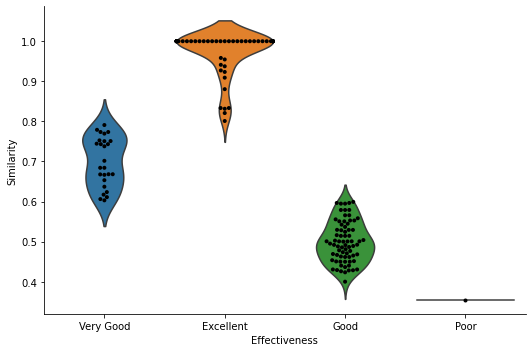

In [245]:
g = sns.catplot(x='Effectiveness', y='Similarity', kind="violin", inner=None, data=df_test,height=5, aspect=1.5)
g = sns.swarmplot(x='Effectiveness', y='Similarity', color="k", size=4, data=df_test, ax=g.ax)
fig = g.get_figure()
fig.savefig('SimilarityVsEffectiveness.png')